## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
# working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 29.3 MB/s eta 0:00:00


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 1.2 Imports

In [ ]:
import os
import random

import albumentations as A
import importlib
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from datasets import load_dataset
from livelossplot import PlotLosses
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)
from typing import List

# Local imports
import utils.data_handler as dh
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(dh)
importlib.reload(mrp)
importlib.reload(metrics)

from utils.metrics import MetricName
from utils.data_handler import DataHandler, MriType, StructuralScan
from utils.mri_plotter import MRIPlotter
np.set_printoptions(precision=16)

### 1.3 Initializations (important!)

In [ ]:
# this class will handle all actions related to saving and loading files
# by default, downloads files into the runtime but saves training data to the cloud
data_handler = DataHandler()

# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [ ]:
# specify which training directory to use
# this will hold all the models generated from maskformer

train_dir_prefix = create_train_dir_by_date()
# train_dir_prefix = 'maskformer/huafeng'
# train_dir_prefix = "maskformer/keith"

# if RETRAIN is False, load from existing model:
RETRAIN = False
model_file_name = "model_all_10epoch_better.pt"
model_train_dir_prefix = "maskformer/huafeng"


RECALCULATE_METRICS = False
metrics_file_name = f"metrics-{str(int( time.time() ))}.joblib"
metrics_dir_prefix = "metrics"

print("metrics_file_name: ", metrics_file_name)

metrics_file_name:  metrics-1687903281.joblib


In [ ]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that train directory
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {train_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer != "YES":
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen directory has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/keith


### 1.4 General functions

In [ ]:
# helper functions
def collate_fn(batch):
    return {
            "pixel_values": torch.stack([example["pixel_values"] for example in batch]),
            "pixel_mask": torch.stack([example["pixel_mask"] for example in batch]),
            "class_labels": [example["class_labels"] for example in batch],
            "mask_labels": [example["mask_labels"] for example in batch],
            "subj_no": [example["subj_no"] for example in batch],
            "file_no": [example["file_no"] for example in batch]
            }

# get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

def softmax(logits):
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def softmax_2d(logits):
    e_x = np.exp(logits - np.max(logits, axis=(0, 1), keepdims=True))
    return e_x / np.sum(e_x, axis=(0, 1), keepdims=True)

In [ ]:
# Reusable functions
def get_subj_ids(subj_files):
    # get unique subj train ids: [0001, 0002, 0003 ..]
    subj_ids = []
    for subj in subj_files:
        subj_id = data_handler.get_mri_subj_id(subj)
        if subj_id not in subj_ids:
            subj_ids.append(subj_id)
    return subj_ids

def get_subset_files(subj_files, subj_ids):
    # filter files within range
    subj_filenames = []
    for file_name in subj_files:
        subj_id = data_handler.get_mri_subj_id(file_name)
        subj_idx = subj_ids.index(subj_id)
        file_no = data_handler.get_mri_file_no(file_name)
        if file_no >= file_no_min and file_no < file_no_max and subj_idx >= subj_id_min and subj_idx < subj_id_max:

            # example:
            # file_name: UPENN-GBM-00006_11_FLAIR_1.nii.gz
            # result: UPENN-GBM-00006_1.nii.gz
            subj_filename = data_handler.get_mri_slice_file_name(file_name)

            # item has to be unique
            if subj_filename not in subj_filenames:
                subj_filenames.append(subj_filename)
    subj_filenames.sort()
    return subj_filenames


### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [ ]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_handler: DataHandler, data_identifier: MriType, data_list: List[str], processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        # valid types: MriType.TRAIN_2D, MriType.VAL_2D, MriType.TRAIN_2d_CROSS and  MriType.VAL_2D_CROSS
        self.mri_type = data_identifier

        self.processor = processor
        self.transform = transform
        self.augment = augment

        # use the Data Handler class to handle all sorts of image loading
        self.data_handler = data_handler

        self.data_list = data_list
        self.n_data = len(self.data_list)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        # find a file corresponding to idx
        item = None
        try:
          item = self.data_list[idx]
        except IndexError:
          item = self.data_list[0]

        subj_no = item.split('.')[0].split('_')[0]
        file_no = item.split('.')[0].split('_')[1]
        # print("Subj no", subj_no)
        # print("File no", file_no)
        # load data file to image and instance_seg
        # return nifti=True to return format before converting to numpy get_fdata

        data_cur, data_cur_nifti = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type,
                                              struct_scan = StructuralScan.FLAIR, return_nifti=True)
        # print(data_cur.shape)
        n_h = data_cur_nifti.shape[0]
        n_w = data_cur_nifti.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        # convert data range from [0 1] to [0 255]
        image[:,:,0] = data_cur * 255
        # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1)
        image[:,:,1] = data_cur * 255

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1GD)
        image[:,:,2] = data_cur * 255

        # load segm file
        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, dtype="uint8")
        instance_seg =  np.zeros( (n_h, n_w), dtype='uint8')
        instance_seg[:,:] = data_cur
        # print(instance_seg.max())
        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 3
        # mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply data augmentation
        if self.augment is True:

            # # Image Color Jittering
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())
            pil_image = Image.fromarray(image.astype(np.uint8))
            color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            pil_image = color_jitter(pil_image)
            image = np.array(pil_image)
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            # convert to tensors
            image = torch.from_numpy(image.astype('float'))
            instance_seg = torch.from_numpy(instance_seg)
            # print("image mean, max=",image[0,:,:].mean(), image[0,:,:].max())

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.2:
                chance1 = random.choice([0,1,2,3,4])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                elif chance1 == 3: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                else: # center
                    image        =        image[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        # apply input transforms, including resize (after cropping)
        if self.transform:
            transformed = self.transform(image=image, mask=instance_seg)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

            image, instance_seg = transformed['image'], transformed['mask']
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

        # Prepare data to fit Maskformer input
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        # add file and subj to input
        inputs["subj_no"] = subj_no
        inputs["file_no"] = file_no

        return inputs


## 2. Process 2D data

### 2.1 load and select data

In [ ]:
# set directories
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

# old functionality
# ! ls $train_dir > $train_list_full
# ! ls $val_dir   > $val_list_full

#### Using below if use all data

In [ ]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_text(file_name = train_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_text(file_name = val_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [ ]:
# list files
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save as text file
data_handler.save_text(file_name = train_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_2d))
data_handler.save_text(file_name = val_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_2d))

100%|██████████| 913M/913M [00:22<00:00, 41.2MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 64241/64241 [00:13<00:00, 4806.02it/s]
100%|██████████| 322M/322M [00:11<00:00, 28.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 21901/21901 [00:04<00:00, 5114.97it/s]


In [ ]:
# selecting slice range
n_total = 146
# file_no_min = n_total//2 - 20
# file_no_max = n_total//2 + 20
file_no_min = 0
file_no_max = n_total + 1

# selecting patent id range
subj_total = 88
# subj_id_min = 0
# subj_id_max = 1
subj_id_min = 0
subj_id_max = subj_total + 1

# Define train and validation dataset
# obtain all train subject ids
subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
                                                  train_dir_prefix=train_dir_prefix)
subj_train_ids = get_subj_ids(subj_train_files)

train_files_unique_c = get_subset_files(subj_train_files, subj_train_ids)
print(f"Number of unique training samples: {len(train_files_unique_c)}")
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_files_unique_c))

# do same for validation
subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
                                                train_dir_prefix=train_dir_prefix)

subj_val_ids = get_subj_ids(subj_val_files)
val_files_unique_c = get_subset_files(subj_val_files, subj_val_ids)
print(f"Number of unique validation samples: {len(val_files_unique_c)}")
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_files_unique_c))


Number of unique training samples: 12848
Number of unique validation samples: 4380


### 2.2 Create Custom PyTorch Dataset


In [ ]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])


train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)

# create datasets
train_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=False)
val_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.VAL_2D, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)

In [ ]:
# setup data loader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
# make label dictionary
id2label = dh.SEGMENTS

# replace the index 4 with 3
if 4 in id2label:
    id2label[3] = id2label[4]
    del id2label[4]

print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


### 2.3 QC dataset

In [ ]:
# peek at the dataset
inputs = train_dataset[120]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
12848
tensor([0, 1, 2, 3])


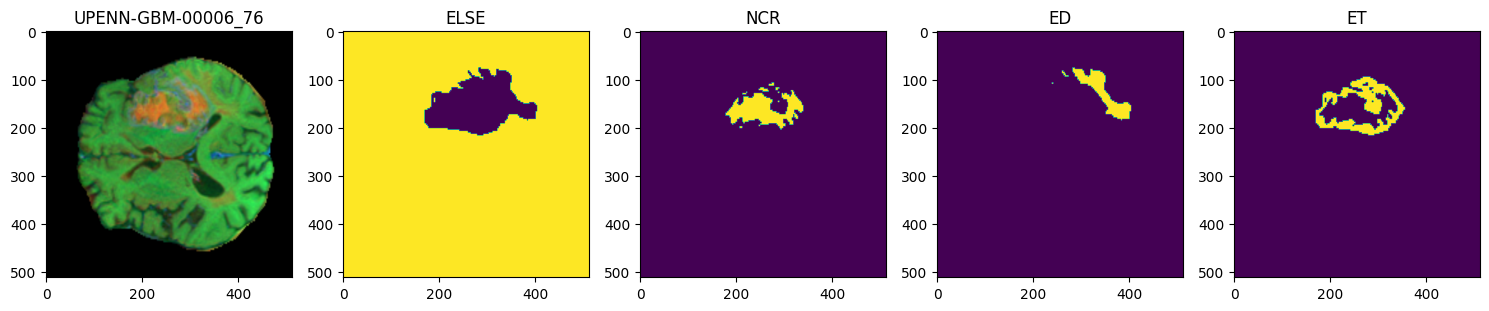

In [ ]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{inputs['subj_no']}_{inputs['file_no']}")

for mask_idx, mask in enumerate(inputs["class_labels"]):
    mask_value = mask.item()
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[mask_value]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

In [ ]:
# peek at the dataset
inputs = val_dataset[120]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
4380
tensor([0, 1, 2, 3])


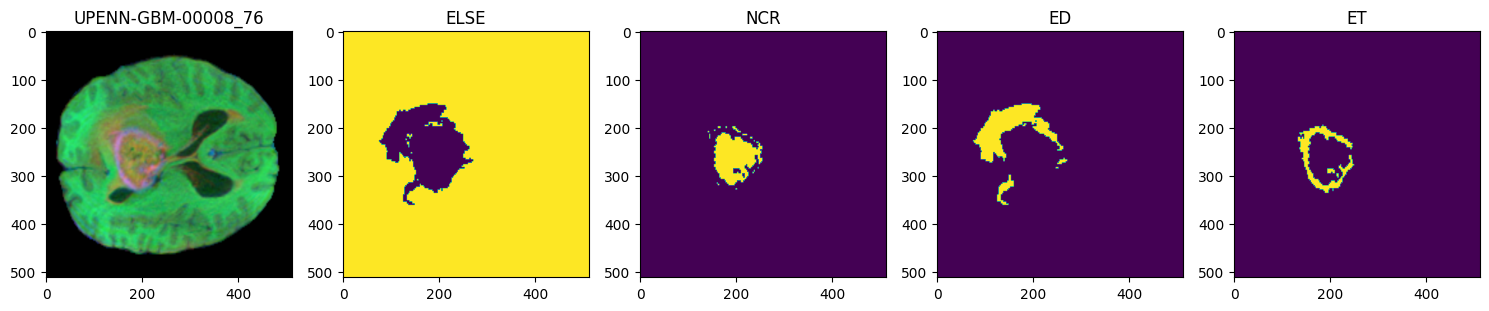

In [ ]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{inputs['subj_no']}_{inputs['file_no']}")

for mask_idx, id in enumerate(inputs["class_labels"]):
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

## 3. Fine-tuning Model

### 3.1 Define the model

In [ ]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# print model config
configuration = model.config
# print(configuration)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 512, 512]     [2, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:',outputs.loss.item())


pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
[torch.Size([4]), torch.Size([2])]
[torch.Size([4, 512, 512]), torch.Size([2, 512, 512])]
Initial Loss is: 2.5478427410125732


In [ ]:
batch["mask_labels"][0].shape

torch.Size([4, 512, 512])

### 3.3 Train the model

In [ ]:
# load saved model if needed
if RETRAIN == False:
  model_steam = data_handler.load_from_stream(file_name=model_file_name, train_dir_prefix=model_train_dir_prefix)
  model = torch.load(model_steam, map_location=device)

In [ ]:
if RETRAIN:
  # training
  liveloss = PlotLosses()

  batch_max = 100000
  loss_train = []
  loss_val = []
  min_loss = 1e9
  # mutiplier is used to scale loss values to be more readable
  loss_multiplier = 10.0

  # define number of epochs in training
  n_epoch = 100

  # saving model half way
  SAVE_INT = n_epoch //2

  # define learning rate
  lr = 2e-5
  # lr = 1e-5
  # lr = 0.5e-5

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)) )
  logs = {}
  # logs['loss'] = loss_init
  # logs['val_loss'] = loss_init

  # liveloss.update(logs)
  # liveloss.send()

  for epoch in range(1,n_epoch+1):
      print("Starting Epoch:", epoch)

      ## training loop
      running_loss = 0.0
      num_samples = 0
      model.train()
      for ibatch, batch in enumerate(tqdm(train_dataloader)):
          # run partial data based on input limit
          if ibatch < batch_max:
              # Reset the parameter gradients
              optimizer.zero_grad()

              # Forward pass
              outputs = model(
                      pixel_values=batch["pixel_values"].to(device),
                      mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                      class_labels=[labels.to(device) for labels in batch["class_labels"]],
              )

              # Backward propagation
              loss = outputs.loss * loss_multiplier
              loss.backward()

              batch_size = batch["pixel_values"].size(0)
              running_loss += loss.item()
              num_samples += batch_size
              loss_train_cur = running_loss/num_samples

              # Optimization
              optimizer.step()
          else:
              # skip where ibatch >= batch_max
              break

      # record loss at the end of each epoch
      logs['loss'] = loss_train_cur
      print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
      loss_train.append(loss_train_cur)

      ## validation loop
      running_loss = 0.0
      num_samples = 0
      model.eval()
      with torch.no_grad():
          for ibatch, batch in enumerate(tqdm(val_dataloader)):
              # run partial data based on input limit
              if ibatch < batch_max:
                  # Forward pass
                  outputs = model(
                          pixel_values=batch["pixel_values"].to(device),
                          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                          class_labels=[labels.to(device) for labels in batch["class_labels"]],
                  )

                  # loss
                  loss = outputs.loss  * loss_multiplier

                  batch_size = batch["pixel_values"].size(0)
                  running_loss += loss.item()
                  num_samples += batch_size
                  loss_val_cur = running_loss/num_samples
              else:
                  # skip where ibatch >= batch_max
                  break

      # record loss at the end of each epoch
      logs['val_loss'] = loss_val_cur
      # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
      loss_val.append(loss_val_cur)

      # if found better model, update min_loss and save model (currently using training loss)

      if min_loss > loss_val_cur:
          print("Saved model in epoch",epoch)
          # save the best model
          # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
          min_loss = loss_val_cur

      # save model regularly
      if epoch%SAVE_INT == 0:
          print("Saved model in epoch",epoch)

          # save the best model
          data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

      # Update the plot with new logging information.
      liveloss.update(logs)
      liveloss.send()

  # save loss at the end
  data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
  data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.1 Model prediction QC on one sample



#### 4.1.1 Model prediction and viualization on one sample

In [ ]:
# create a test data loader without shuffling

# QC_TYPE = 'train'
QC_TYPE = 'val'

if QC_TYPE == 'train':
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# obtain one batch of data
target_batch = 60

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 1

# values: -2.117904 to 2.1734028
test_image =  test_batch["pixel_values"][test_idx]

# [512, 512] values of. why?
test_pixel_mask = test_batch["pixel_mask"][test_idx]

# values: 0 to 1, 4 items of 512, 512
test_mask_label = test_batch["mask_labels"][test_idx]

# [0, 1, 2, 3]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2


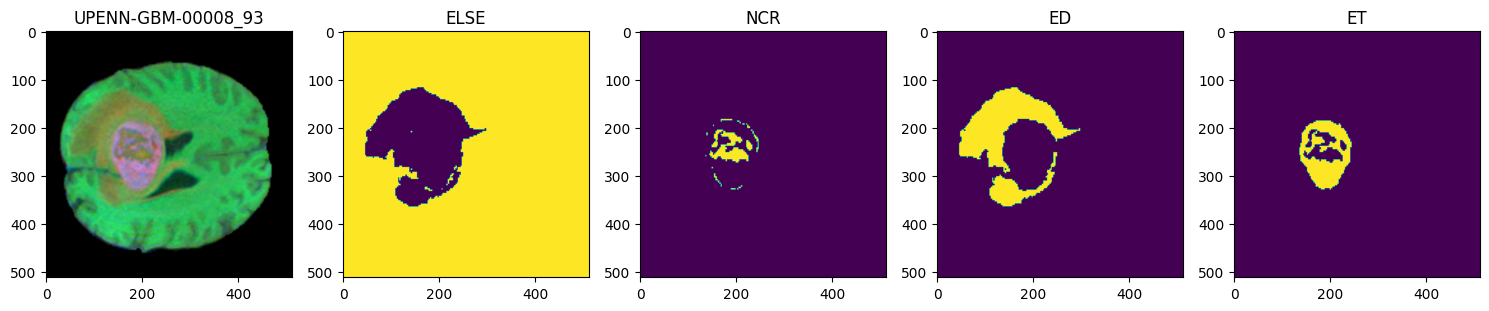

In [ ]:
# Visualize input data
true_img = {}

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{test_subj}")

for mask_idx, label in enumerate(test_class_labels):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    label_id = label.item()
    true_img[label_id] = img
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[label_id]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()


In [ ]:
# load one batch of data and make predictions
model.to(device)

model.eval()
with torch.no_grad():
    outputs = model(
            pixel_values=test_image.unsqueeze(0).to(device),
            mask_labels=[test_mask_label.to(device)],
            class_labels=[test_class_labels.to(device)],
        )

torch.cuda.empty_cache()

# post-processing of output
target_size = transforms.ToPILImage()(test_image).size[::-1]
# target_size = (163, 193)
results = processor.post_process_instance_segmentation(outputs, target_sizes=[target_size])[0]

print(results['segments_info'])
print(test_image.shape)
print(results['segmentation'].shape)

[{'id': 0, 'label_id': 1, 'was_fused': False, 'score': 0.896251}, {'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.940847}, {'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.943787}, {'id': 3, 'label_id': 0, 'was_fused': False, 'score': 0.991705}]
torch.Size([3, 512, 512])
torch.Size([512, 512])


In [ ]:
np.unique(results['segmentation'])

array([-1.,  0.,  1.,  2.,  3.], dtype=float32)

In [ ]:
# Obtain labels in true, predict, intersection and union

labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )
# remove duplicates
labels_pred = list(set(labels_pred))

labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['ET', 'ED', 'NCR', 'ELSE']
All labels: ['ELSE', 'ED', 'NCR', 'ET']
Common labels: ['ELSE', 'ED', 'ET', 'NCR']


Visualizing mask for instance: ELSE
label_id is: 0
Visualizing mask for instance: NCR
label_id is: 1
Visualizing mask for instance: ED
label_id is: 2
Visualizing mask for instance: ET
label_id is: 3


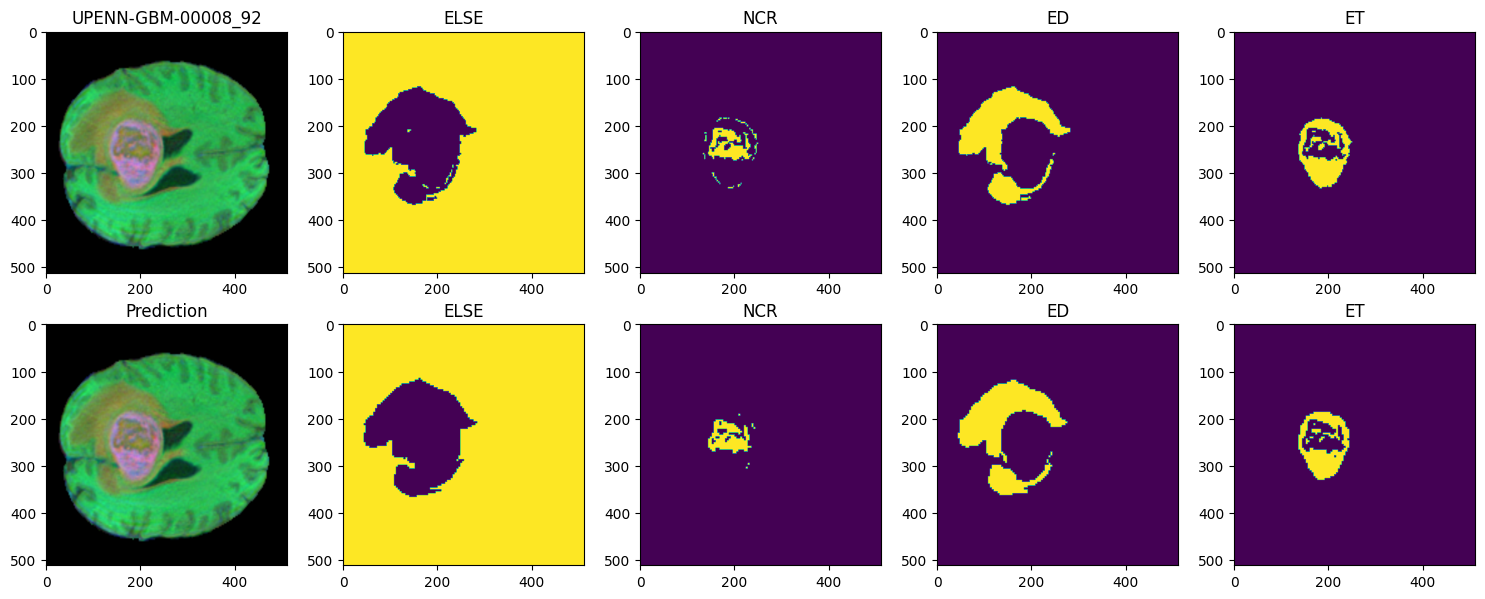

In [ ]:
# visual QC predicted masks

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

mask_preds = {}

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid
mask_pred = np.zeros((len(id_list)))
for mask_idx, id in enumerate(id_list):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

for mask_idx, id in enumerate(id_list):
    mask_pred = np.zeros((results['segmentation'].shape[0],results['segmentation'].shape[1]))

    # find information in results
    for item in results['segments_info']:
        if item['label_id'] == id:
            segment = item
            mask_pred += np.array( get_mask(results['segmentation'], segment['id']) )

    mask_pred = mask_pred.astype(np.uint8)
    mask_preds[id] = mask_pred

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    axs[1,mask_idx+1].imshow(mask_pred)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0,0].imshow(unnormalized_image)
axs[0,0].set_title(f"{test_subj}")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Prediction")

plt.tight_layout()
plt.show()

#### 4.1.2 Visualization of model output (Optional)

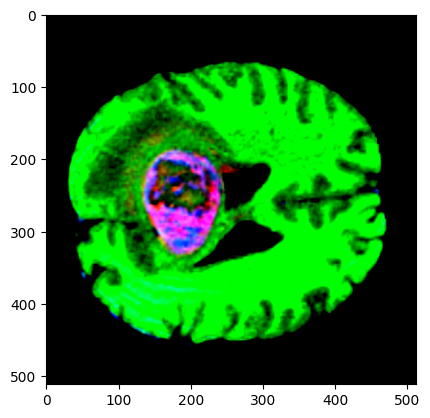

In [ ]:
# display first image
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


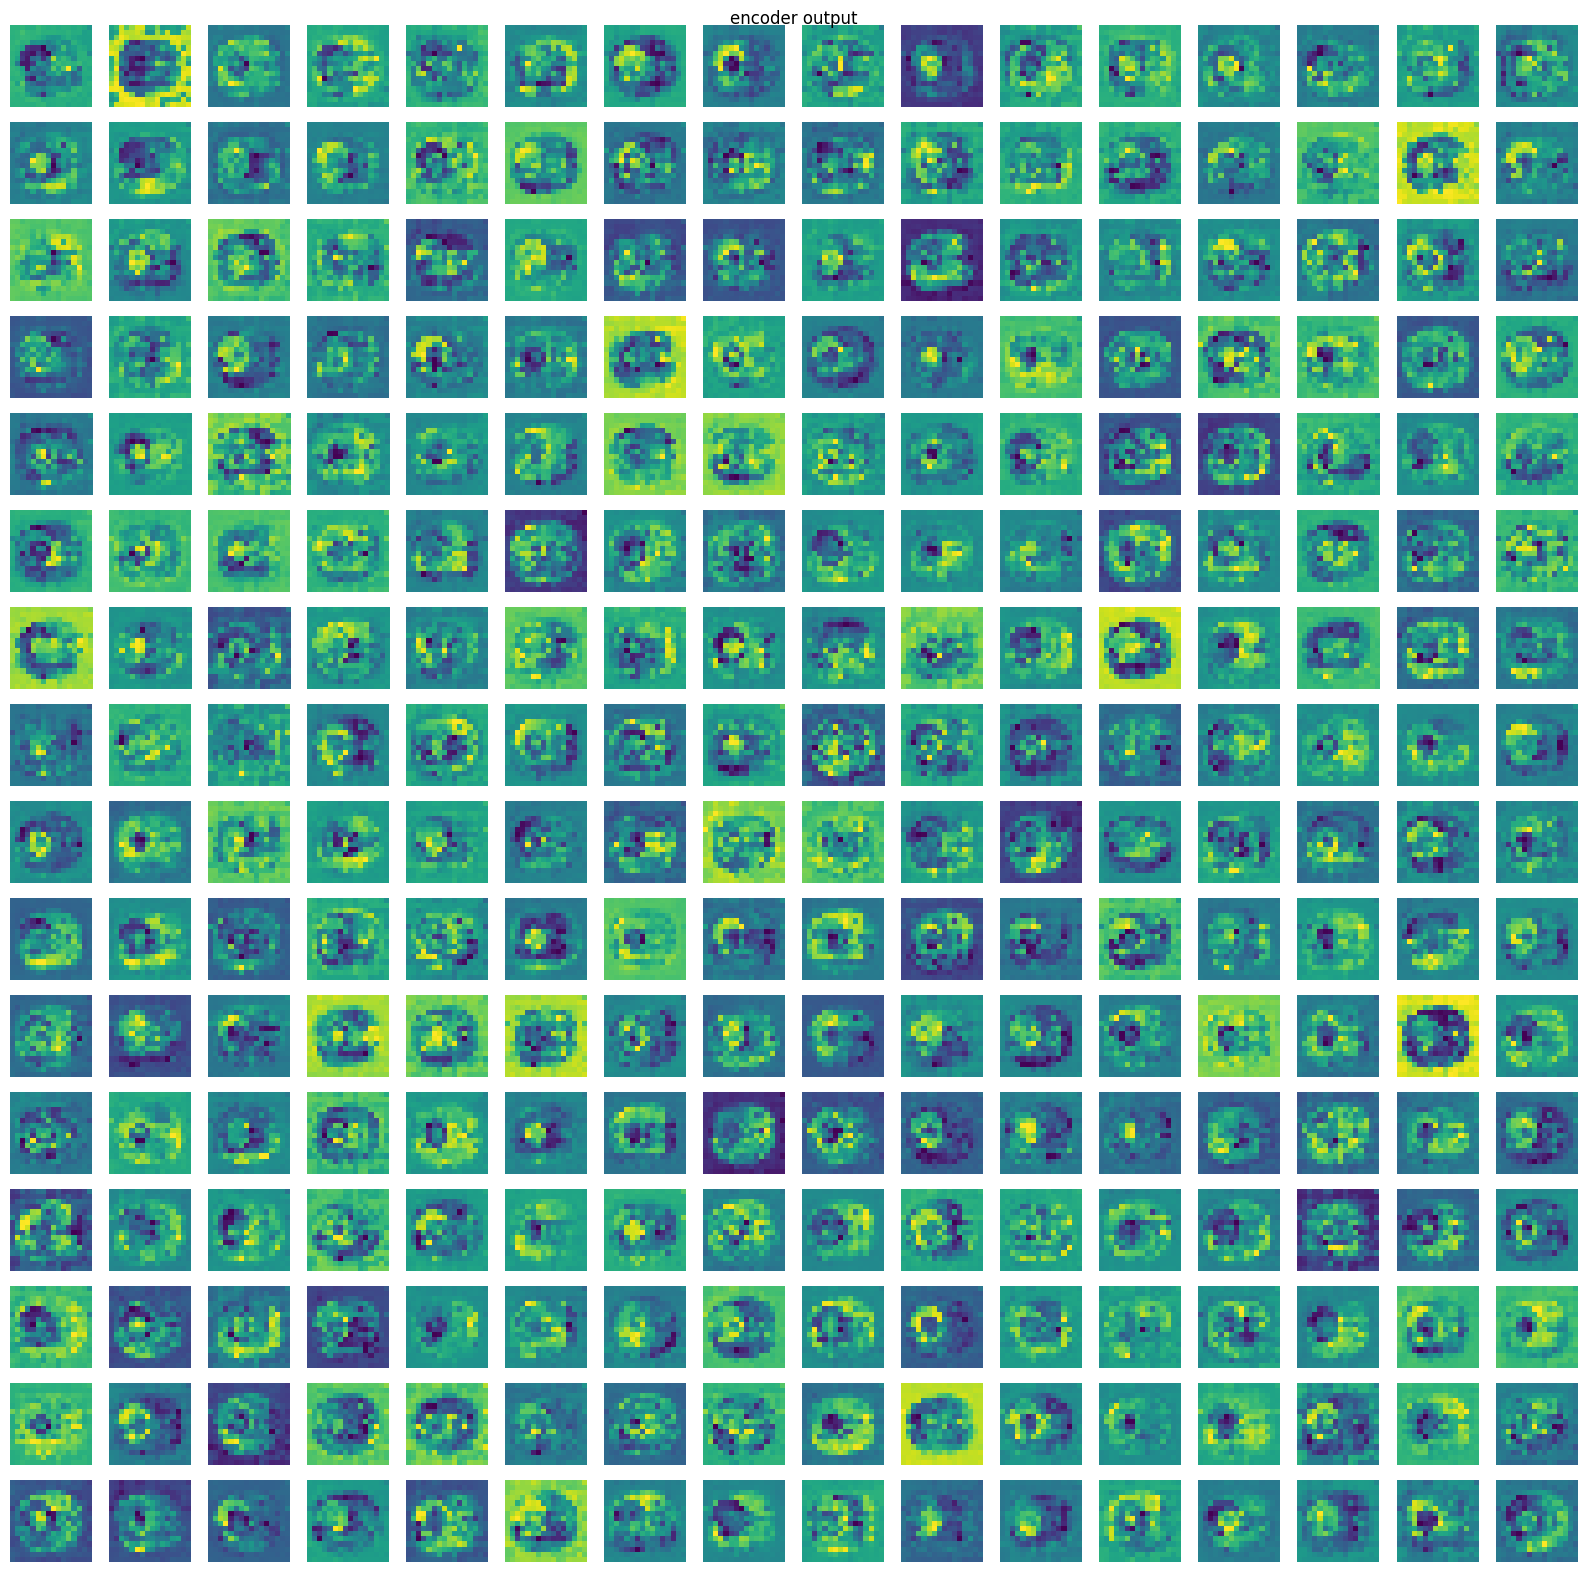

In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [ ]:
# visualize the last layer of the pixel decodeer

n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

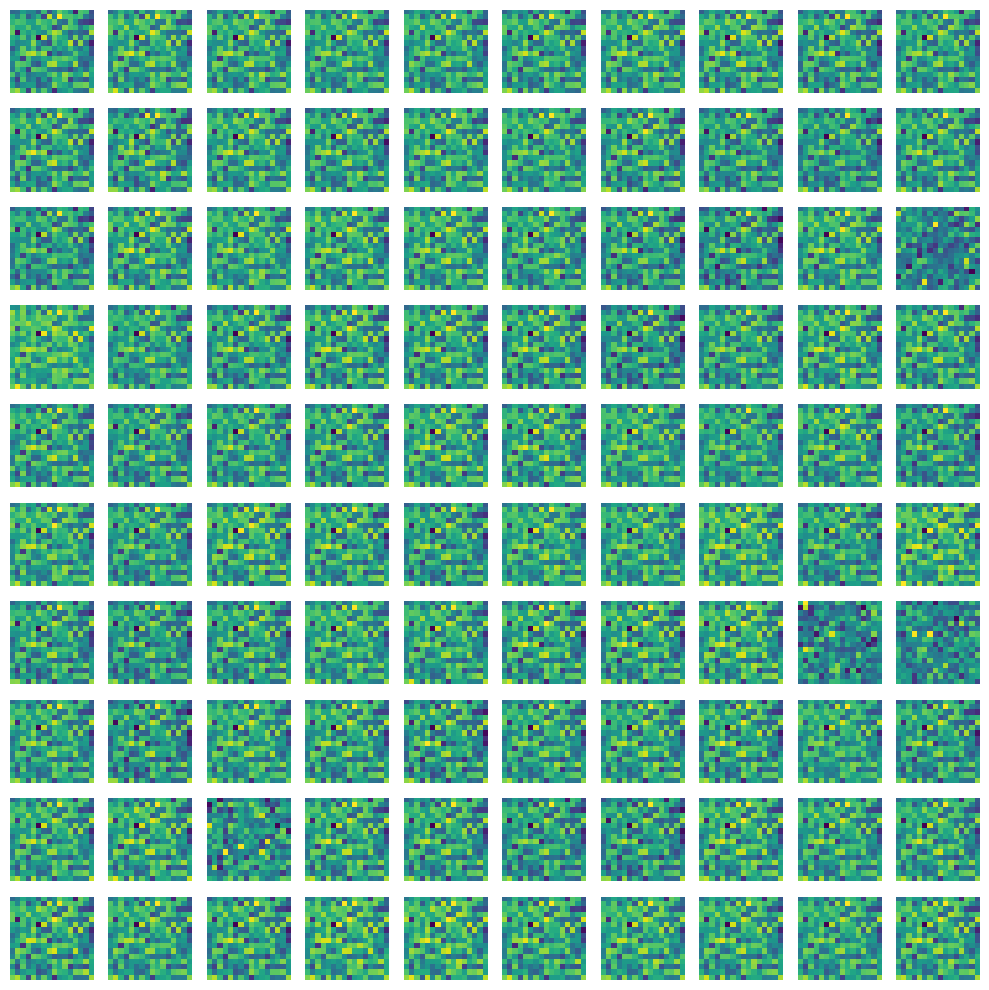

In [ ]:
# visualize the last layer of the transformer decodeer

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,idx,:].detach().cpu().numpy().reshape((16,16))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

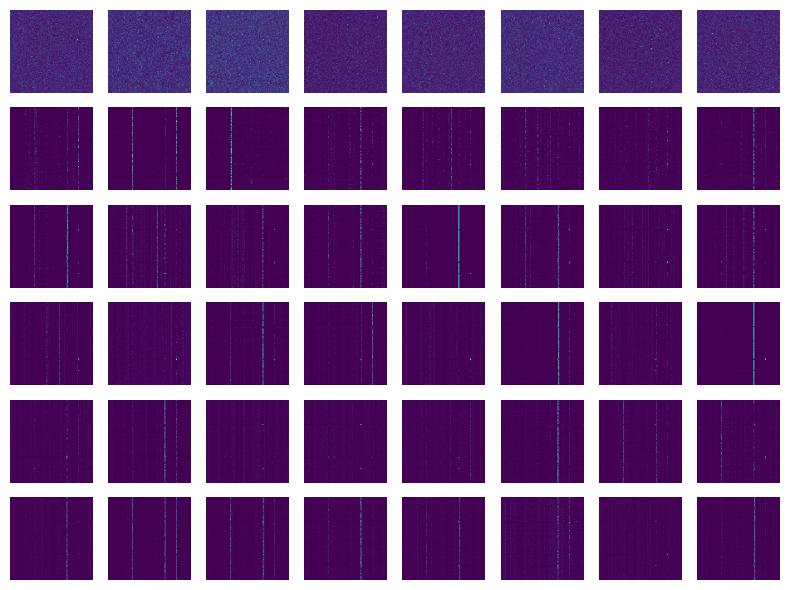

In [ ]:
#visualize the attention map

n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

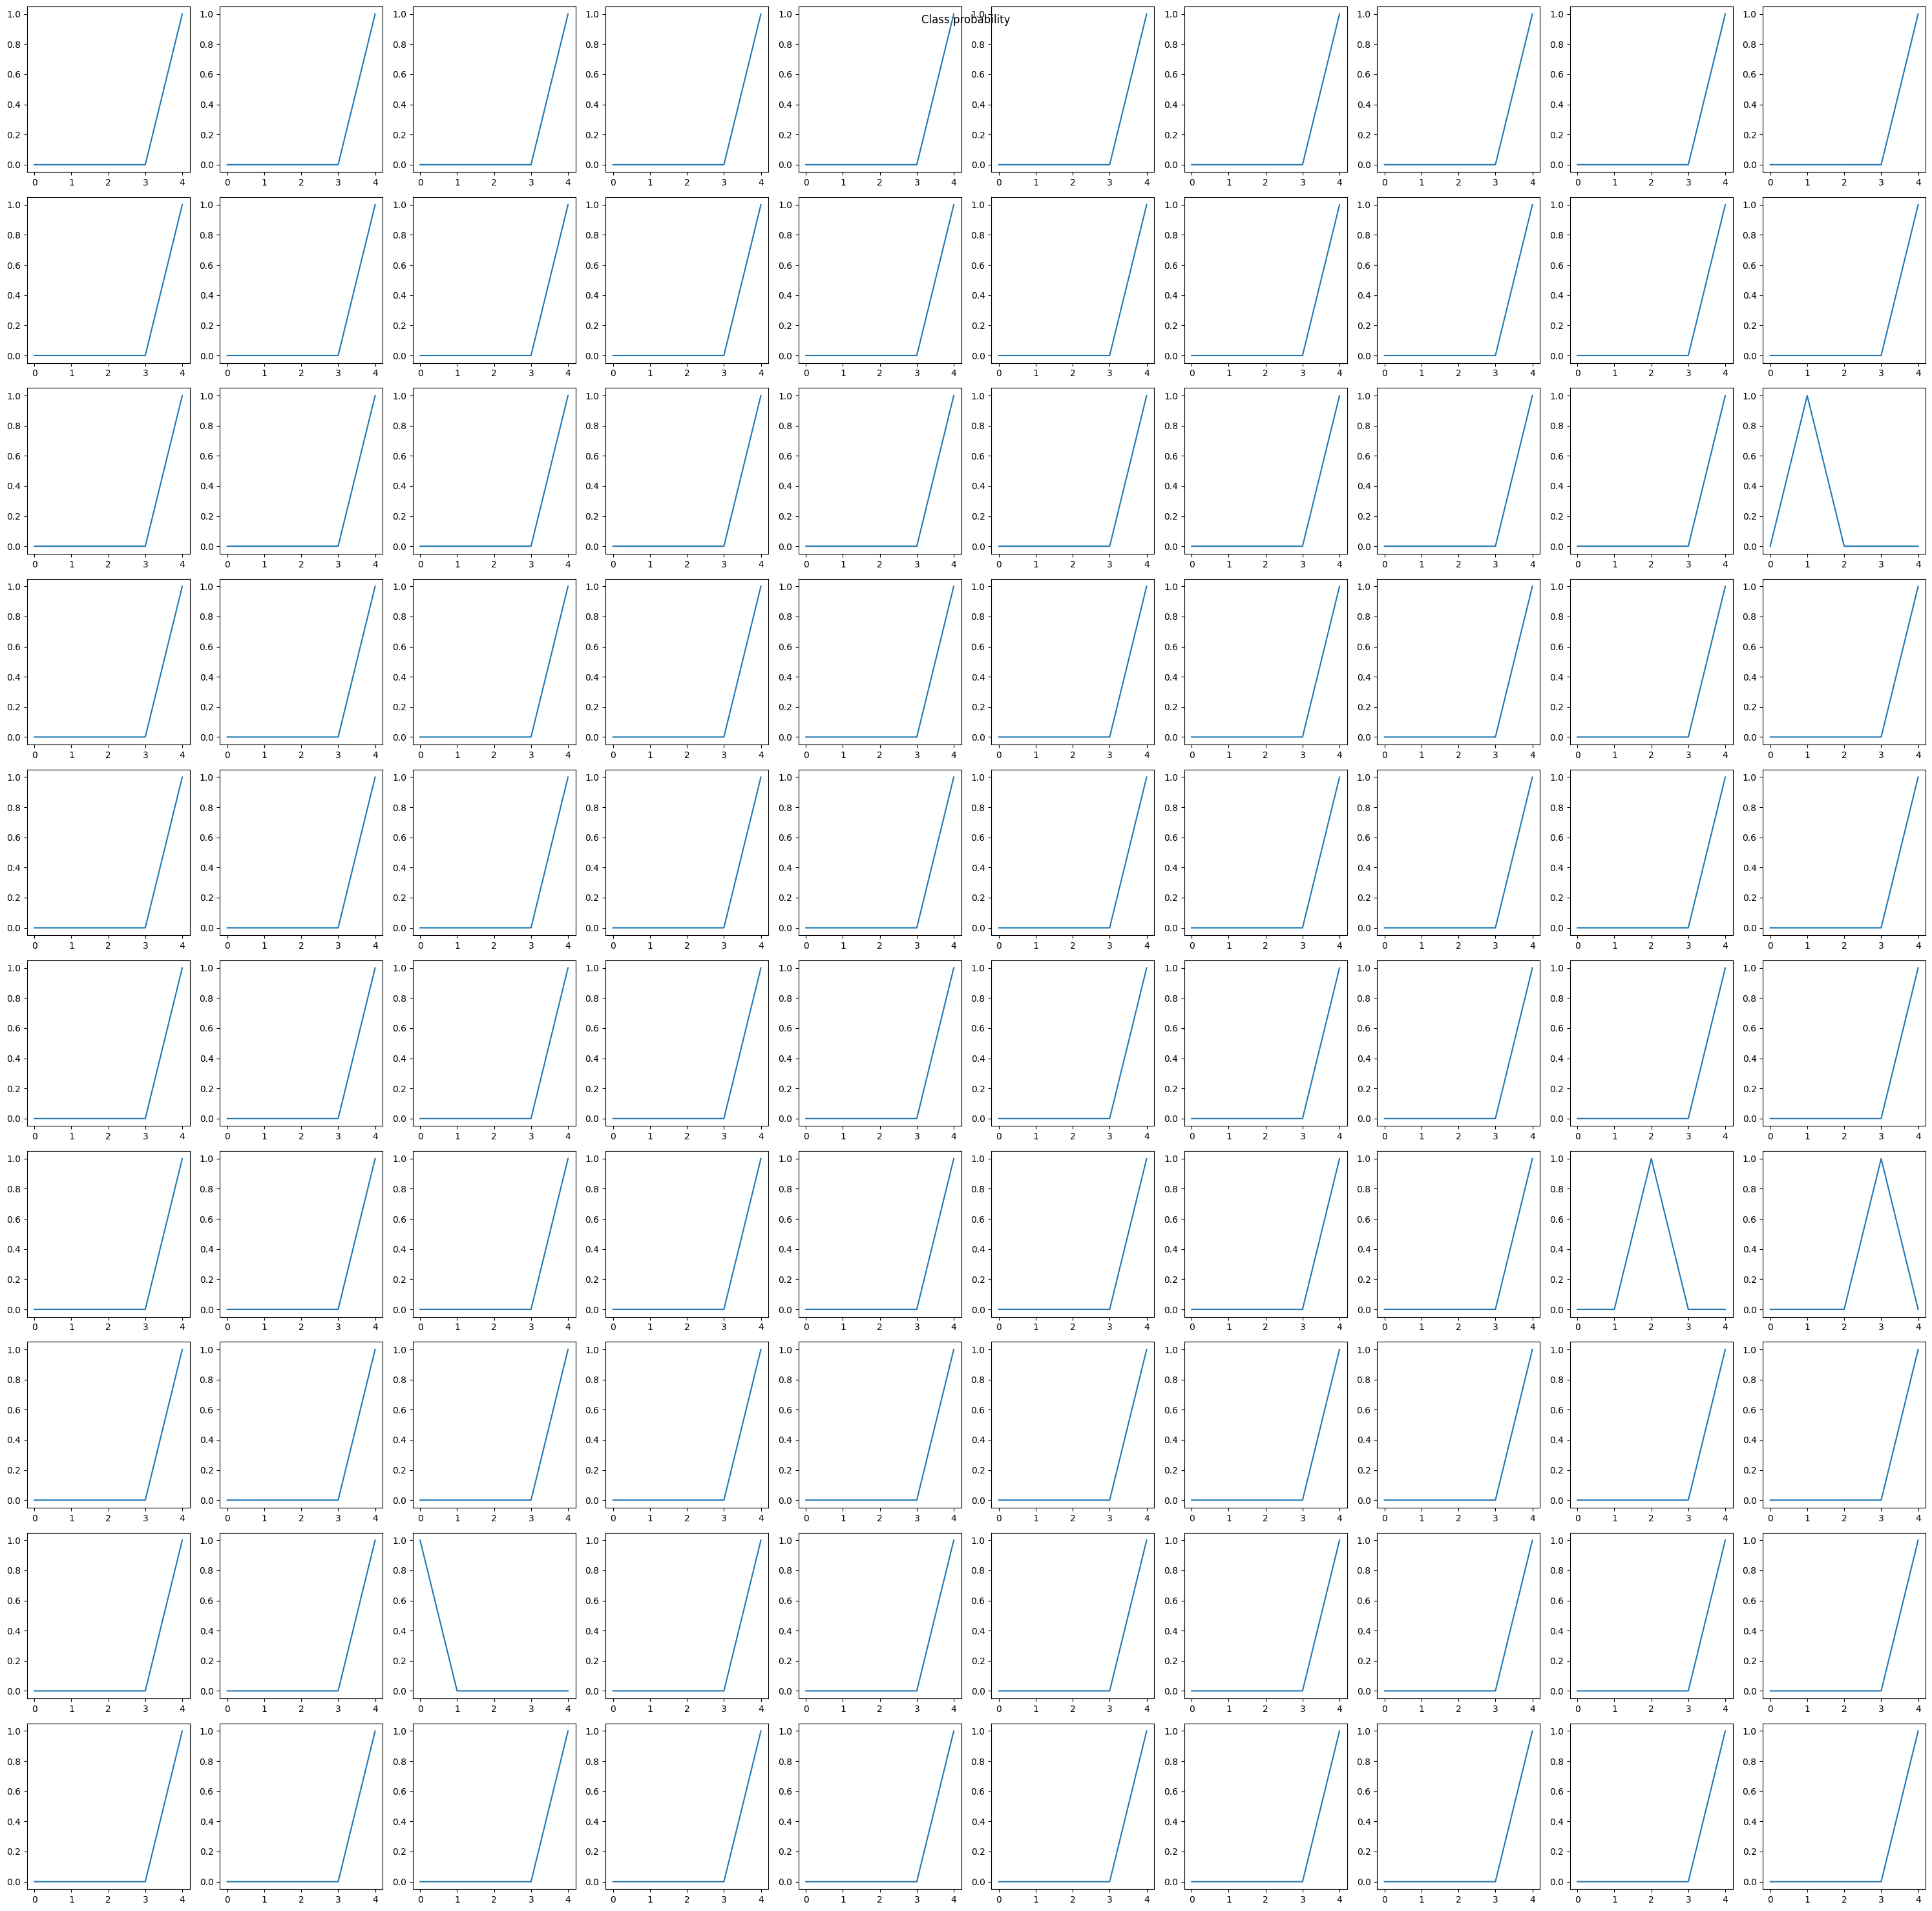

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation

img_size = outputs.pixel_decoder_last_hidden_state.shape[-1]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_size*img_size)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_size, img_size).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


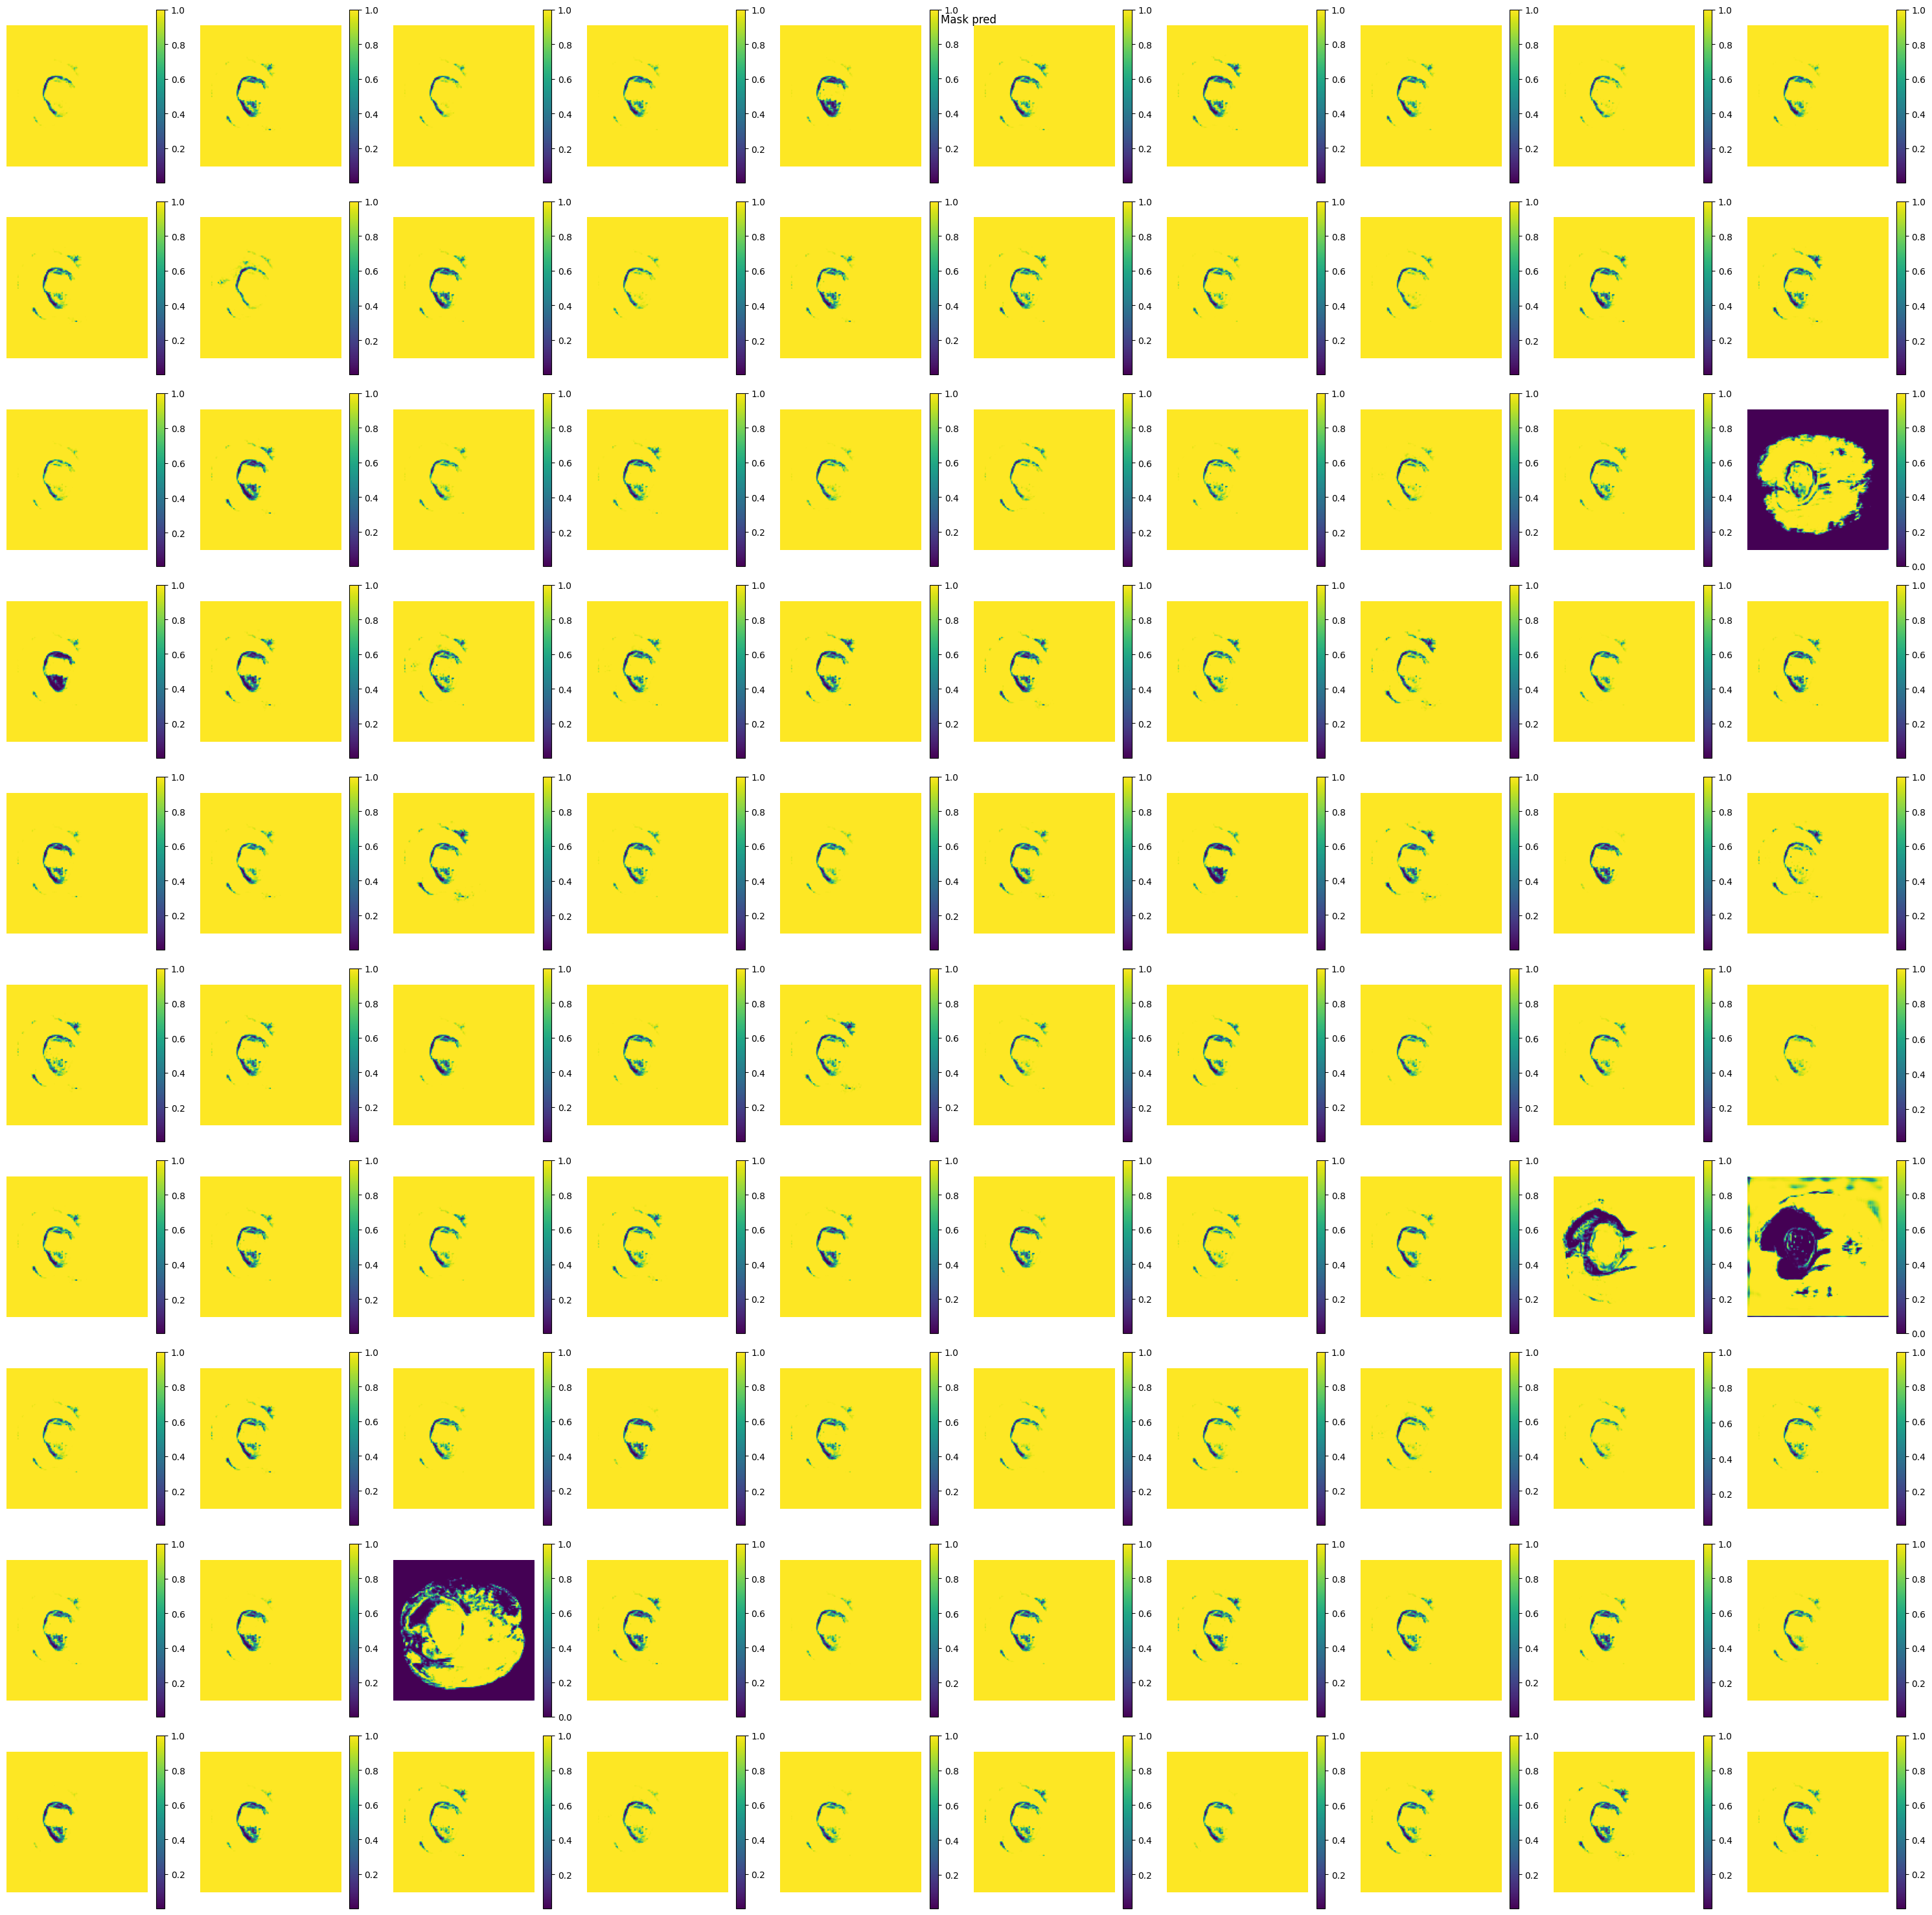

In [ ]:
# visualize mask prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


In [ ]:
print('shape of class probability is:',class_probs.shape)
print('shape of predicted mask is:',mask_pred.shape)

shape of class probability is: (100, 5)
shape of predicted mask is: (512, 512)


torch.Size([128, 128])


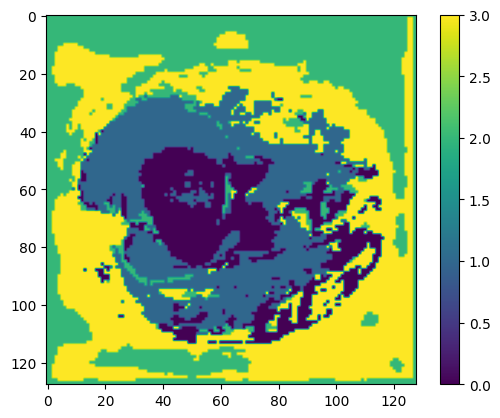

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_size*img_size)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_size,img_size)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()

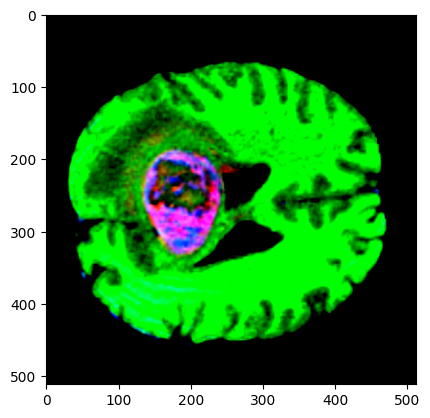

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)

#### 4.1.3 Calcualte metrics on one sample

In [ ]:
for label_id, true_mask_pil in true_img.items():
  print(f"Metrics for {id2label[label_id]}:")
  true_mask = (np.array(true_mask_pil)/255).astype(np.uint8)
  if label_id in mask_preds:
    pred_mask_pil = mask_preds[label_id]
    pred_mask = (np.array(pred_mask_pil)/255).astype(np.uint8)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)

    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

  else:
    print(f"Segment {id2label[label_id]} does not exist in prediction")

  print("")
  # calc_binary_metrics(segm_pred, segm_true, segm_id)

Metrics for ELSE:
Specificity 0.9911840660156134
Sensitivity 0.9908953623251844
Precision 0.9986897367120774
Recall 0.9908953623251844
Dice Score 0.994777281945479
HD95 5.0

Metrics for NCR:
Specificity 0.9975692963752665
Sensitivity 0.773724368144969
Precision 0.8380681818181818
Recall 0.773724368144969
Dice Score 0.8046119514009422
HD95 26.590398201248387

Metrics for ED:
Specificity 0.9949853584079239
Sensitivity 0.9458907363420428
Precision 0.9427556818181818
Recall 0.9458907363420428
Dice Score 0.944320607066635
HD95 4.123105625617661

Metrics for ET:
Specificity 0.9981001107611777
Sensitivity 0.8693901716992303
Precision 0.9383946830265849
Recall 0.8693901716992303
Dice Score 0.9025754502427931
HD95 3.0



### 4.2 Make predictions and compute metrics

#### 4.2.1 Obtain data list for all validation data

In [ ]:
# get slices from list of validation 2d slices: val_2d

# construct the unique list of slices from val 2d
# val_2d: [UPENN-GBM-00006_11_FLAIR_1.nii.gz, UPENN-GBM-00006_11_T1_1.nii.gz, UPENN-GBM-00006_11_FLAIR_2.nii.gz...]
# unique slices per subj: UPENN-GBM-00006_1.nii.gz, UPENN-GBM-00006_2.nii.gz
validation_files = list(set([data_handler.get_mri_slice_file_name(val_file) for val_file in val_2d]))
validation_files[:10]

['UPENN-GBM-00020_128.nii.gz',
 'UPENN-GBM-00249_81.nii.gz',
 'UPENN-GBM-00124_85.nii.gz',
 'UPENN-GBM-00124_96.nii.gz',
 'UPENN-GBM-00131_20.nii.gz',
 'UPENN-GBM-00264_100.nii.gz',
 'UPENN-GBM-00205_95.nii.gz',
 'UPENN-GBM-00249_9.nii.gz',
 'UPENN-GBM-00151_65.nii.gz',
 'UPENN-GBM-00020_4.nii.gz']

In [ ]:
# get unique subj_ids
validation_subjs = [data_handler.get_mri_subj(val_file) for val_file in validation_files]
validation_subjs = sorted(list(set(validation_subjs)))

print("total validation data", len(validation_subjs))

print("first 10")
validation_subjs[:10]

total validation data 30
first 10


['UPENN-GBM-00008',
 'UPENN-GBM-00013',
 'UPENN-GBM-00020',
 'UPENN-GBM-00030',
 'UPENN-GBM-00033',
 'UPENN-GBM-00054',
 'UPENN-GBM-00075',
 'UPENN-GBM-00086',
 'UPENN-GBM-00100',
 'UPENN-GBM-00101']

#### 4.2.2. Make predictions on all validation data

In [ ]:
id_list = list(id2label.keys())
id_list

[0, 1, 2, 3]

In [ ]:
def get_slices_for_subj(file_list, subj):
    # if subj: (UPENN-GBM-00013) is in the filename e.g (UPENN-GBM-00013_24.nii.gz), include that file in the list of slices
    val_vol_list = [file_name for file_name in file_list if subj in file_name]

    # sort the list according to slice number: UPENN-GBM-00013_01.nii.gz, UPENN-GBM-00013_02.nii.gz ...
    val_vol_list_sorted = sorted(val_vol_list, key=lambda x: int(x.split('_')[1].split('.')[0]))
    return val_vol_list_sorted

In [ ]:
def predict_val_data(model, data_handler, vol_3d, processor, transform):
    # expected: 146
    num_slices = len(vol_3d)

    # define a new dataset
    val_metric_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.VAL_2D,
                                            data_list=vol_3d, processor=processor,
                                            transform=transform, augment=False)
    # define data loader
    batch_size_metrics = 1
    val_metric_dataloader = DataLoader(val_metric_dataset, batch_size=batch_size_metrics,
                                      shuffle=False, collate_fn=collate_fn)

    # eg. initalize 3d variables using shape of first input
    first_img_shape = val_metric_dataset[0]["pixel_values"].shape

    # create arrays to hold 3d volumes
    image_3d = np.zeros((num_slices, first_img_shape[0], first_img_shape[1], first_img_shape[2]), dtype=np.float32)
    mask_pred_3d = np.zeros((len(id_list), num_slices, first_img_shape[1], first_img_shape[2]), dtype=np.uint8)
    mask_true_3d = np.zeros((len(id_list), num_slices, first_img_shape[1], first_img_shape[2]), dtype=np.uint8)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(val_metric_dataloader):

            # forward pass
            output_cur = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # post-processing of output
            # get first item in batch where batch size = 1
            image_cur = batch["pixel_values"][0]
            image_3d[ibatch, :, :, :] = image_cur.numpy()

            result_cur = processor.post_process_instance_segmentation(output_cur,
                                                                      target_sizes=[transforms.ToPILImage()(image_cur).size[::-1]])[0]

            # obtain predicted_mask
            for mask_idx, id in enumerate(id_list):
                # 512x512
                mask_pred_cur = np.zeros((result_cur['segmentation'].shape[0], result_cur['segmentation'].shape[1]))

                # find predicted masks in results
                for item in result_cur['segments_info']:
                    # get label id from segments_info
                    if item['label_id'] == id:
                        mask_pred_cur += result_cur['segmentation'].cpu().numpy() == item['id']
                        # combine segment in case the id appears twice
                        # mask_pred_cur = np.logical_or(mask_pred_cur, result_cur['segmentation'].cpu().bool().numpy() == item['id'])

                    elif item['label_id'] == -1:
                        subj_no = batch["file_no"][0]
                        file_no = batch["file_no"][0]
                        print(f"{subj_no}_{file_no} has -1 segmentation")

                mask_pred_cur = mask_pred_cur.astype(np.uint8)
                mask_pred_3d[mask_idx, ibatch, :, :] = mask_pred_cur

            # obtain true mask where available
            # [4, 512, 512]
            mask_labels_cur = batch["mask_labels"][0]
            for idx in range(mask_labels_cur.shape[0]):
                mask_true_3d[idx, ibatch, :, :] = mask_labels_cur[idx,:,:].bool().numpy().astype(np.uint8)

    return image_3d, mask_true_3d, mask_pred_3d

def calc_metric_all_segments(label_ids, metric_func, mask_pred_3d, mask_true_3d):
    results = []
    for label_id in label_ids:
      true_mask_cur = mask_true_3d[label_id,:,:,:].squeeze()
      pred_mask_cur = mask_pred_3d[label_id,:,:,:].squeeze()
      result = metric_func(pred_mask_cur, true_mask_cur)
      results.append(result)
    return results

In [ ]:
RECALCULATE_METRICS = True

In [ ]:
metrics_dict = {}
all_dice = []
all_hd95 = []
all_common_metrics = []
error_files = []

if RECALCULATE_METRICS:

    # predict all validation data
    start = time.time()

    image_3d, mask_true_3d, mask_pred_3d = None, None, None
    for val_subj in validation_subjs:
        print("Calculating metrics for ", val_subj)

        # get slices for each subj
        vol_3d = get_slices_for_subj(validation_files, val_subj)
        image_3d, mask_true_3d, mask_pred_3d = predict_val_data(model, data_handler, vol_3d, processor, train_transform)

        try:
            # dice coefficient
            # output array of dice score for all segments: [0.9, 0.8, 0.92, 0.3]
            dice_score = calc_metric_all_segments(id_list, metrics.calc_dice_score, mask_pred_3d, mask_true_3d)

            # 95% hausdorff distance
            # output array of hd95 for all segments: [5.3, 2.8, 3.92, 1]
            hausdorff_val = calc_metric_all_segments(id_list, metrics.calc_hausdorff_95, mask_pred_3d, mask_true_3d)

            if hausdorff_val is None or hausdorff_val == np.inf:
              raise Exception(f"Error calculating hausroff_val: {val_subj}")


            # common metrics
            # since the output is list of dictionary for each segment,
            # re-organize the dictionary to create 1 dictionary with the scores for the 4 segments
            # e.g. 'true_positive': [20927582, 148267, 687623, 226880]
            common_metrics = calc_metric_all_segments(id_list, metrics.calc_binary_metrics, mask_pred_3d, mask_true_3d)
            common_metrics_dict = {}
            for key in common_metrics[0]:
              common_metrics_dict[key] = [metric[key] for metric in common_metrics]


            # append only when there is no error:
            all_dice.append(dice_score)
            all_hd95.append(hausdorff_val)
            all_common_metrics.append(common_metrics_dict)

        except Exception as ex:
            print(f"Error {val_subj}", ex)
            error_files.append(val_subj)

    end = time.time()
    print("elapsed time", str(end - start))

    print("errors", error_files)
    success_val_files = list(filter(lambda x: x not in error_files, validation_subjs))

    print(f"New length after removing problematic images: {len(success_val_files)}")
    success_val_files_np = np.array(success_val_files)

    metrics_dict = {'success_val_files': success_val_files,
                      'success_val_files_np': success_val_files_np,
                      'error_files': error_files,
                      'all_dice': all_dice,
                      'all_hd95': all_hd95,
                      'all_common_metrics': all_common_metrics}

    # dump data to temp file
    metrics_temp_file = data_handler.create_temp_file(metrics_file_name)
    joblib.dump(metrics_dict, metrics_temp_file)

    # upload to cloud
    data_handler.save_from_source_path(file_name=metrics_file_name, source_path=metrics_temp_file,
                                      train_dir_prefix=metrics_dir_prefix, use_cloud=True)
else:
    metrics_temp_file = data_handler.load_to_temp_file(file_name=metrics_file_name,
                                                       train_dir_prefix=metrics_dir_prefix)

    metrics_dict = joblib.load(metrics_temp_file)

Calculating metrics for  UPENN-GBM-00008
Calculating metrics for  UPENN-GBM-00013
Calculating metrics for  UPENN-GBM-00020
Calculating metrics for  UPENN-GBM-00030
Calculating metrics for  UPENN-GBM-00033
Calculating metrics for  UPENN-GBM-00054
Calculating metrics for  UPENN-GBM-00075
Calculating metrics for  UPENN-GBM-00086
Calculating metrics for  UPENN-GBM-00100
Calculating metrics for  UPENN-GBM-00101
Calculating metrics for  UPENN-GBM-00105
Calculating metrics for  UPENN-GBM-00118
Calculating metrics for  UPENN-GBM-00124
Calculating metrics for  UPENN-GBM-00131
Calculating metrics for  UPENN-GBM-00140
Calculating metrics for  UPENN-GBM-00144
Calculating metrics for  UPENN-GBM-00151
Calculating metrics for  UPENN-GBM-00205
Calculating metrics for  UPENN-GBM-00206
Calculating metrics for  UPENN-GBM-00217
Calculating metrics for  UPENN-GBM-00240
Calculating metrics for  UPENN-GBM-00249
Calculating metrics for  UPENN-GBM-00253
Calculating metrics for  UPENN-GBM-00259
Calculating metr

#### 4.2.3 Print Statistics

In [ ]:
all_label_names = list(id2label.values())

def display_statistics(metric_scores, metric_name, label_names):
    print("Summary:", metric_name)
    df = pd.DataFrame(metric_scores, columns=label_names)
    print(df.describe())

In [ ]:
success_val_files = metrics_dict["success_val_files"]
success_val_files_np = metrics_dict["success_val_files_np"]
error_files = metrics_dict["error_files"]
all_dice = metrics_dict["all_dice"]
all_hd95 = metrics_dict["all_hd95"]
all_common_metrics = metrics_dict["all_common_metrics"]

In [ ]:
# combine all data in one dictionary and convert everything to a numpy array
# the use of Enum is to avoid typos: MetricName.PRECISION.value = "precision"
metrics_dict = {
    MetricName.PRECISION.value: np.array([metric[MetricName.PRECISION.value] for metric in all_common_metrics]),
    MetricName.RECALL.value: np.array([metric[MetricName.RECALL.value] for metric in all_common_metrics]),
    MetricName.SENSITIVITY.value: np.array([metric[MetricName.SENSITIVITY.value] for metric in all_common_metrics]),
    MetricName.SPECIFICITY.value: np.array([metric[MetricName.SPECIFICITY.value] for metric in all_common_metrics]),
    MetricName.DICE_SCORE.value: np.array(all_dice),
    MetricName.HD95.value: np.array(all_hd95)
}

In [ ]:
for key, np_val in metrics_dict.items():
  display_statistics(np_val, key, all_label_names)
  print("\n")

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.945905   0.832520   0.565961   0.785988
std     0.070669   0.127293   0.166969   0.102321
min     0.737164   0.445411   0.190814   0.478861
25%     0.940699   0.818031   0.438535   0.741272
50%     0.966017   0.861345   0.583281   0.821917
75%     0.985572   0.915050   0.687886   0.855554
max     0.999317   0.951168   0.888187   0.925467


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.994529   0.280784   0.864546   0.851485
std     0.002178   0.240707   0.055011   0.060452
min     0.988589   0.001018   0.736166   0.664443
25%     0.993252   0.046952   0.841401   0.846500
50%     0.994838   0.300405   0.879594   0.860919
75%     0.995835   0.425493   0.902365   0.887226
max     0.998237   0.882274   0.933497   0.934478


Summary: sensitivity
            ELSE        NCR         ED  

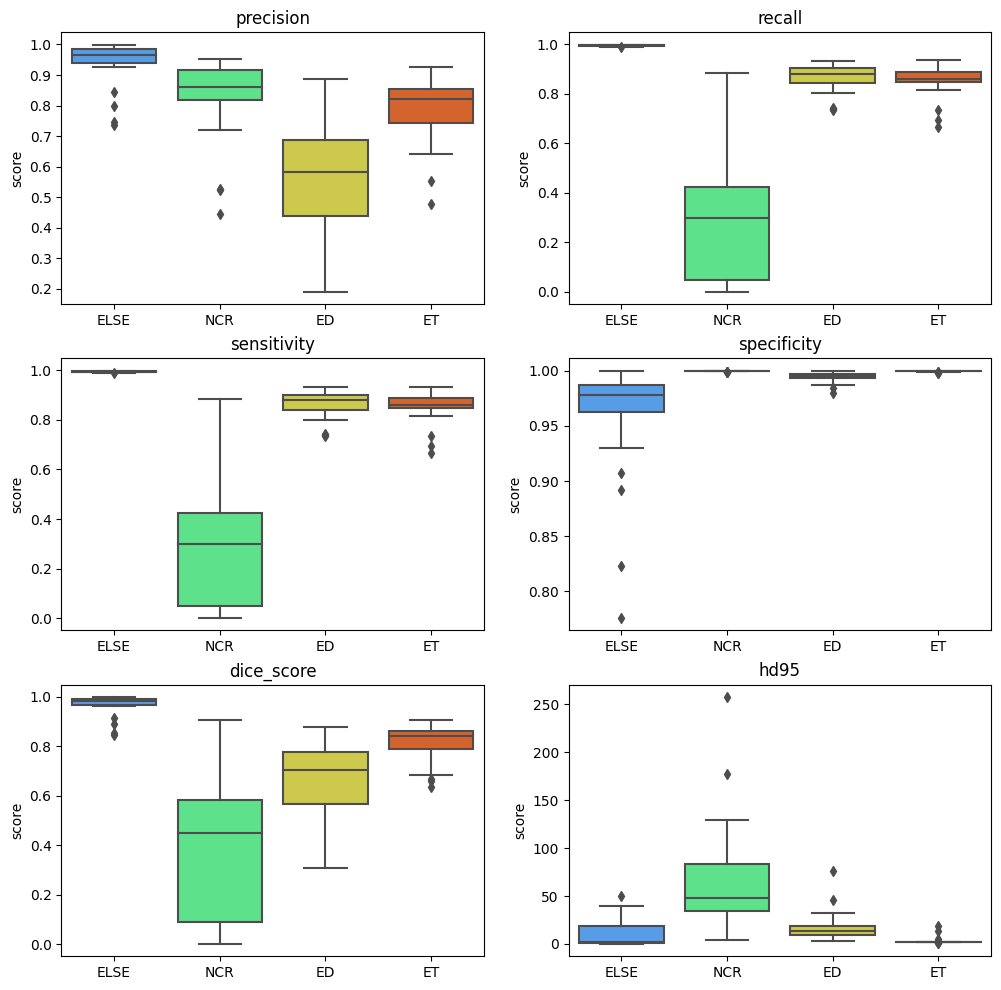

In [ ]:
nrows = 3
ncols = 2

def draw_box_plot(metric_scores, metric_name, label_names, ax):
  sns.boxplot(data=metric_scores,  palette="turbo", ax=ax)
  ax.set_xticks(range(len(label_names)), label_names)
  ax.set_ylabel("score")
  ax.set_title(metric_name)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

count = 0
for key, np_val in metrics_dict.items():
  row = count//ncols
  col = count%ncols
  ax = axs[row, col]
  draw_box_plot(np_val, key, all_label_names, ax)
  count+=1

plt.show()

#### 4.2.3 Histograms

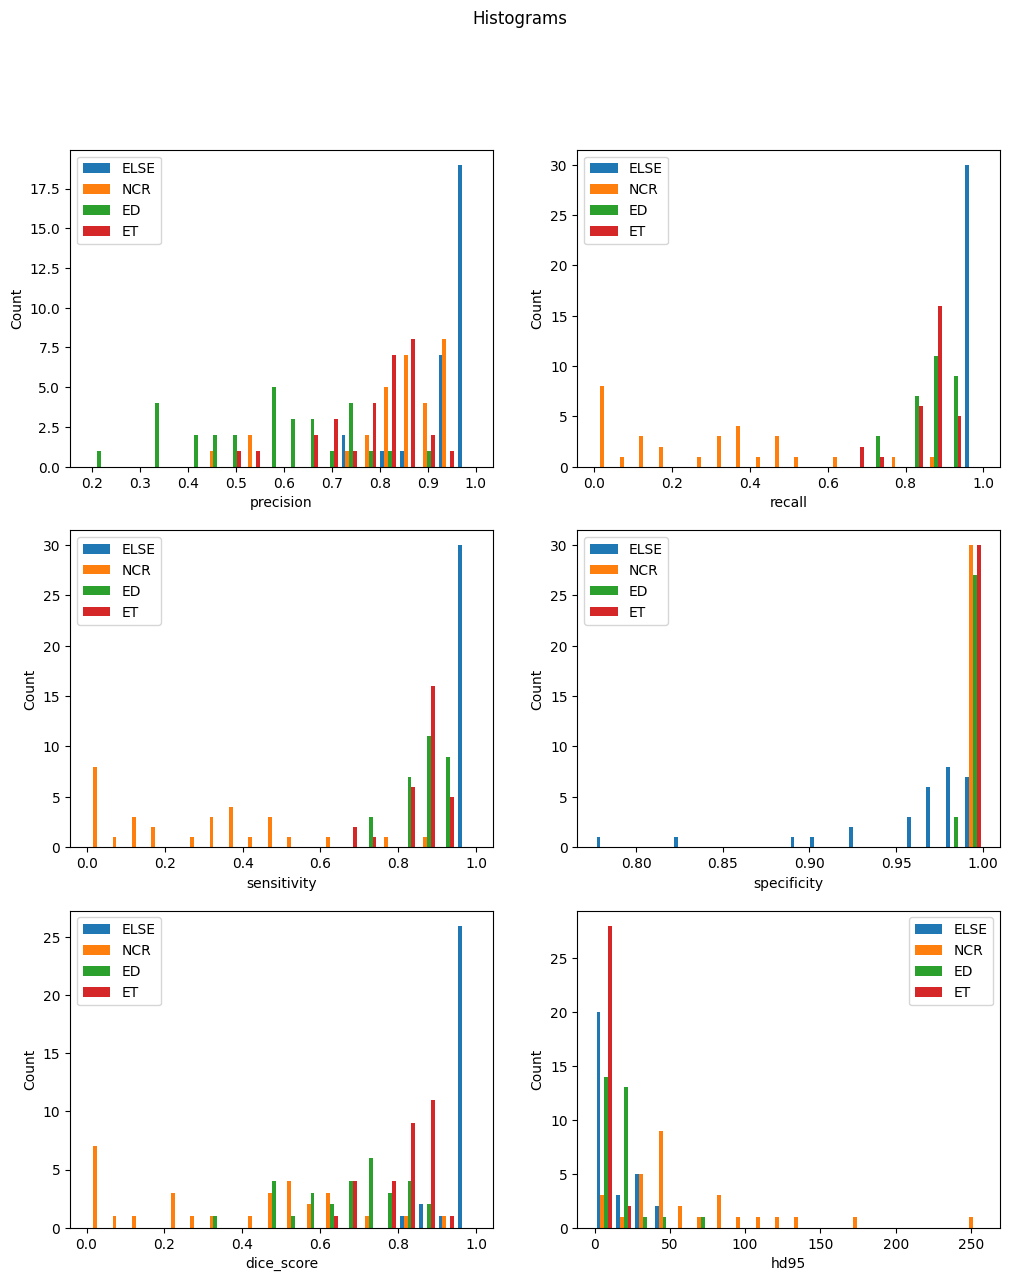

In [ ]:
nrows = 3
ncols = 2

def build_histogram(metric_scores, metric_name, label_names, ax):
    x0 = metrics_dict[metric_name][:, 0]
    x2 = metrics_dict[metric_name][:, 1]
    x3 = metrics_dict[metric_name][:, 2]
    x4 = metrics_dict[metric_name][:, 3]
    ax.hist([x0, x2, x3, x4], bins = 20, label=label_names)
    ax.legend()
    ax.set_xlabel(metric_name)
    ax.set_ylabel('Count')

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))

count = 0
for key, np_val in metrics_dict.items():
  row = count//ncols
  col = count%ncols
  ax = axs[row, col]
  build_histogram(np_val, key, all_label_names, ax)
  count+=1

plt.suptitle("Histograms")
plt.show()

#### QC 3D volume by slicing in 3 directions

In [ ]:
vol_3d = get_slices_for_subj(validation_files, "UPENN-GBM-00008")
image_3d, mask_true_3d, mask_pred_3d = predict_val_data(model, data_handler, vol_3d, processor, train_transform)

Visualizing mask for instance: ELSE
label_id is: 0
Visualizing mask for instance: NCR
label_id is: 1
Visualizing mask for instance: ED
label_id is: 2
Visualizing mask for instance: ET
label_id is: 3


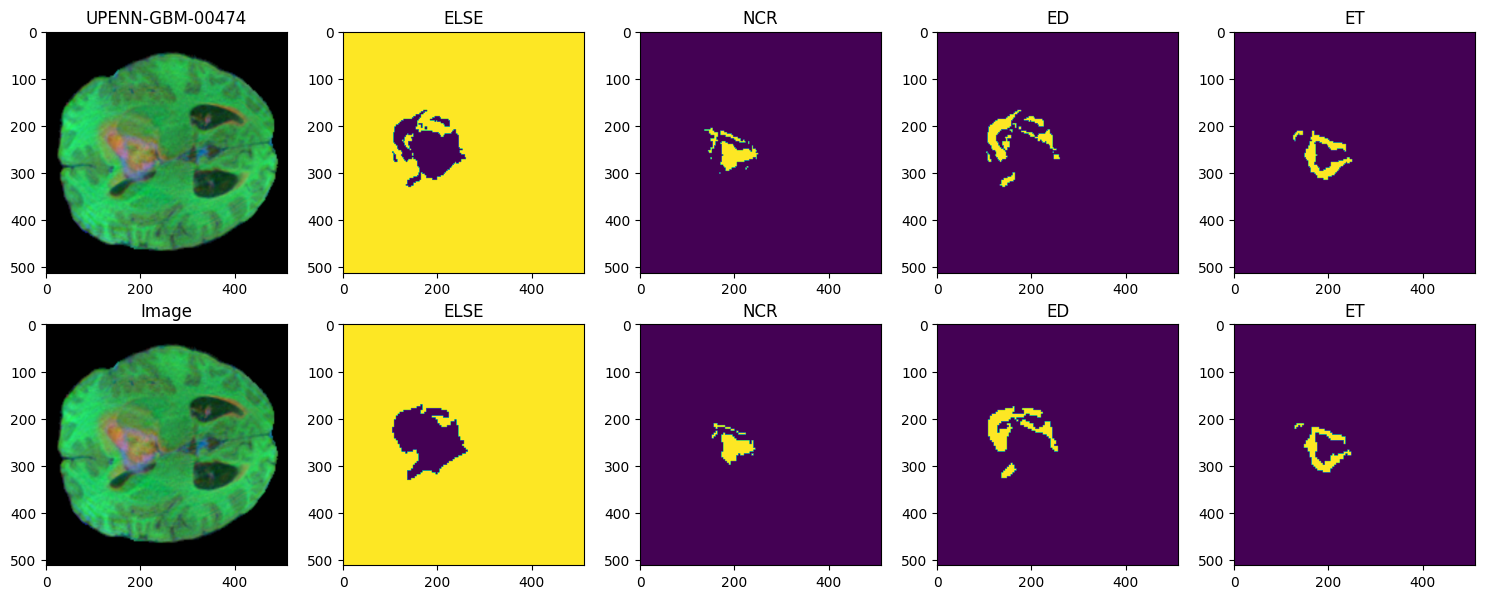

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

slice_no = 70

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

mask_pred = np.zeros((len(id_list)))

for mask_idx, id in enumerate(id_list):
    mask_cur = mask_true_3d[mask_idx, slice_no,:,:]
    img = Image.fromarray(mask_cur)
    axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    mask_cur = mask_pred_3d[mask_idx, slice_no,:,:]
    axs[1,mask_idx+1].imshow(mask_cur)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

unnormalized_image = ( image_3d[slice_no,:,:,:] * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0,0].imshow(unnormalized_image)
axs[0,0].set_title(f"{success_val_files[-1]}")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Image")

plt.tight_layout()
plt.show()

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

# n_image = len(id2label)+1
# id_list = list(id2label.keys())
# id_list.sort()

# slice_no = 200

# fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

# mask_pred = np.zeros((len(id_list)))

# for mask_idx, id in enumerate(id_list):
#     mask_cur = mask_true_3d[mask_idx,:,slice_no,:]
#     img = Image.fromarray(mask_cur)
#     axs[0,mask_idx+1].imshow(img)
#     axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

#     label = id2label[id]
#     print("Visualizing mask for instance:", label)
#     print("label_id is:", id )

#     mask_cur = mask_pred_3d[mask_idx,:,slice_no,:]
#     axs[1,mask_idx+1].imshow(mask_cur)
#     axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

# unnormalized_image = ( image_3d[:,:,slice_no,:] * np.array(ADE_STD)[None,:,None] ) + np.array(ADE_MEAN)[None,:,None]
# unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 1, -1)

# axs[0,0].imshow(unnormalized_image)
# axs[0,0].set_title(f"Image")

# axs[1,0].imshow(unnormalized_image)
# axs[1,0].set_title(f"Image")

# plt.tight_layout()
# plt.show()

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

# n_image = len(id2label)+1
# id_list = list(id2label.keys())
# id_list.sort()

# slice_no = 200

# fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

# mask_pred = np.zeros((len(id_list)))

# for mask_idx, id in enumerate(id_list):
#     mask_cur = mask_true_3d[mask_idx,:,:,slice_no]
#     img = Image.fromarray(mask_cur)
#     axs[0,mask_idx+1].imshow(img)
#     axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

#     label = id2label[id]
#     print("Visualizing mask for instance:", label)
#     print("label_id is:", id )

#     mask_cur = mask_pred_3d[mask_idx,:,:,slice_no]
#     axs[1,mask_idx+1].imshow(mask_cur)
#     axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

# unnormalized_image = ( image_3d[:,:,:,slice_no] * np.array(ADE_STD)[None,:,None] ) + np.array(ADE_MEAN)[None,:,None]
# unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 1, -1)

# axs[0,0].imshow(unnormalized_image)
# axs[0,0].set_title(f"Image")

# axs[1,0].imshow(unnormalized_image)
# axs[1,0].set_title(f"Image")

# plt.tight_layout()
# plt.show()

## Back-up